In [104]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import thinkstats2

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)


<h1>Time Series</h1>

The regression analysis we've done have the same basic format - we know some stuff (X values), and we will use that stuff to predict what we want (Y value). Time series analysis is slightly different, here we still want to make predictions for some target value, however we will use previous values for that target as our "X values". In other words, we're making predictions based on movement patterns in a value. 

Time series analysis is common with many things that move or change over time - most notably is technical analysis in stock markets. Technical analysis attempts to predict the price of stocks based on patterns in the stock price movement, rather than by looking at company fundamentals like earnings, sales, or growth. In other traded commodities like gas prices, corn futures, or gold values, time series analysis is also common. 

<h3>Moving Averages</h3>

The basis of time series analysis is a moving average - or taking the previous N values, averaging them together, and using that as a prediction for "next time". We looked at this when we started examining error a few weeks ago. 

In [17]:
#Get some data
tsla = yf.Ticker("TSLA")
c = yf.Ticker("C")
aapl = yf.Ticker("AAPL")

In [96]:
#Download some ticker history
d_tsla = tsla.history(start="2019-01-01", end="2021-11-01")
d_c = c.history(start="2019-01-01", end="2021-11-01")
d_aapl = aapl.history(start="2019-01-01", end="2021-11-01")
d_tsla.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,61.220001,63.026001,59.759998,62.023998,58293000,0,0.0
2019-01-03,61.400002,61.880001,59.476002,60.071999,34826000,0,0.0
2019-01-04,61.200001,63.599998,60.546001,63.537998,36970500,0,0.0
2019-01-07,64.344002,67.348000,63.549999,66.991997,37756000,0,0.0
2019-01-08,68.391998,68.802002,65.403999,67.070000,35042500,0,0.0
2019-01-09,67.099998,68.699997,66.293999,67.706001,27164500,0,0.0
2019-01-10,66.879997,69.078003,66.358002,68.994003,30282000,0,0.0
2019-01-11,68.417999,69.681999,67.753998,69.452003,25195500,0,0.0
2019-01-14,68.475998,68.500000,66.800003,66.879997,26236500,0,0.0


<AxesSubplot:xlabel='Date', ylabel='Close'>

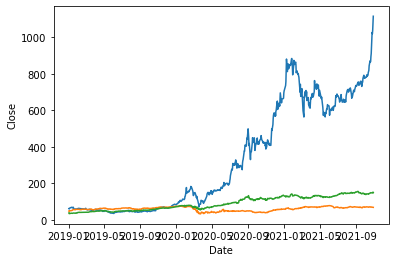

In [19]:
sns.lineplot(data=d_tsla, x="Date", y="Close")
sns.lineplot(data=d_c, x="Date", y="Close")
sns.lineplot(data=d_aapl, x="Date", y="Close")

<h3>Stock Charts - Cool</h3>

Ok, simple analysis time - moving averages...

The most simple type of prediction that we can make is a moving/rolling average - a moving average makes a prediction by averaging together the previous X values. We did this with gas prices when we explored the RMSE. 

In [44]:
d_tsla.head(11)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,dayNum
Date,,,,,,,,
2019-01-02,61.220001,63.026001,59.759998,62.023998,58293000,0,0.0,1
2019-01-03,61.400002,61.880001,59.476002,60.071999,34826000,0,0.0,2
2019-01-04,61.200001,63.599998,60.546001,63.537998,36970500,0,0.0,3
2019-01-07,64.344002,67.348000,63.549999,66.991997,37756000,0,0.0,4
2019-01-08,68.391998,68.802002,65.403999,67.070000,35042500,0,0.0,5
2019-01-09,67.099998,68.699997,66.293999,67.706001,27164500,0,0.0,6
2019-01-10,66.879997,69.078003,66.358002,68.994003,30282000,0,0.0,7
2019-01-11,68.417999,69.681999,67.753998,69.452003,25195500,0,0.0,8
2019-01-14,68.475998,68.500000,66.800003,66.879997,26236500,0,0.0,9


In [43]:
#Rolling average
interval = 10
rollTsla = d_tsla["Close"].rolling(interval, closed="left").mean()
rollTsla.head(11)

Date
2019-01-02        NaN
2019-01-03        NaN
2019-01-04        NaN
2019-01-07        NaN
2019-01-08        NaN
2019-01-09        NaN
2019-01-10        NaN
2019-01-11        NaN
2019-01-14        NaN
2019-01-15        NaN
2019-01-16    66.1614
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date', ylabel='Close'>

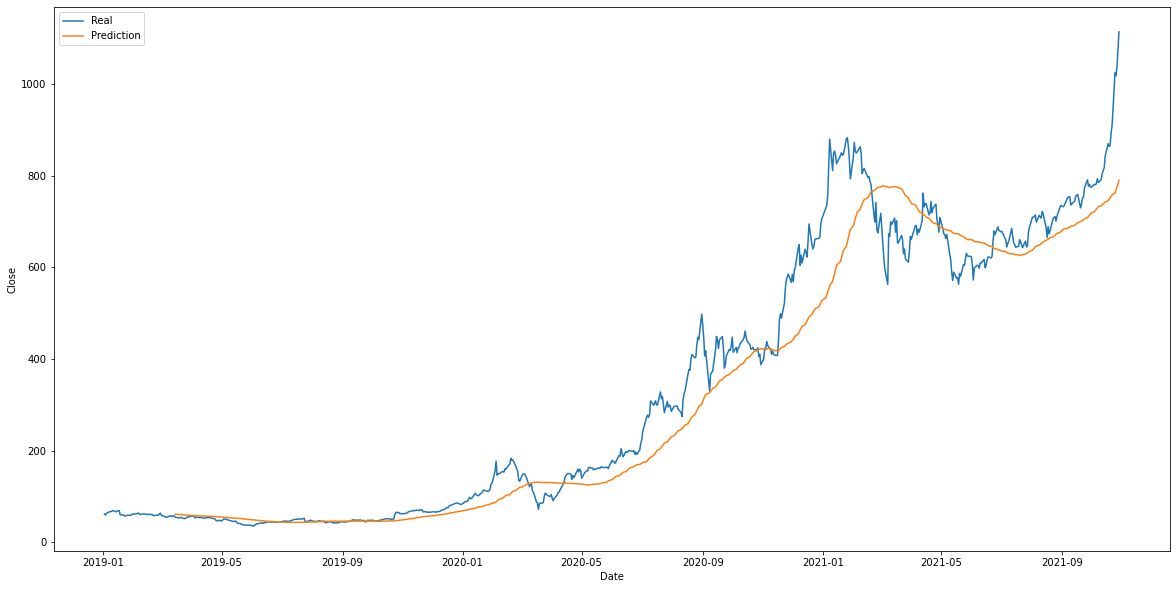

In [30]:
sns.lineplot(data=d_tsla, x="Date", y="Close", label="Real")
sns.lineplot(data=rollTsla, label="Prediction")

As expected, the rolling average follows the real price. If we cut down on the interval, we get a model that is responsive, and changes quickly. If we increase the interval, we get a model that is more stable and smooth. 



In [45]:
#Calculate accuracy
#We need to ensure that we cut out the nans, so we don't start the caclulation until predictions are made
mean_squared_error(d_tsla["Close"][interval:], rollTsla[interval:], squared=False)

32.54710375072656

If we are particularly keen, we could try a whole bunch of different intervals, and see which is most accurate. 

In [46]:
def rollingTest(data, columnName, minRange, maxRange):
    errors = []
    i = minRange
    while i < maxRange:
        roll = data[columnName].rolling(i, closed="left").mean()
        err = mean_squared_error(data[columnName][i:], roll[i:], squared=False)
        errors.append((i,err))
        i += 1
    return errors
        

In [53]:
tmp = rollingTest(d_tsla, "Close", 5, 10)
print(tmp)
#We can also sort the results to see the best. 
tmp2 = sorted(tmp, key=lambda x: x[1])
print(tmp2)

[(5, 23.98343039753664), (6, 25.86592214509921), (7, 27.64598816618618), (8, 29.308444259430406), (9, 30.914398217028698)]
[(5, 23.98343039753664), (6, 25.86592214509921), (7, 27.64598816618618), (8, 29.308444259430406), (9, 30.914398217028698)]


We can create a big loop that tries each and every interval, and we can choose the most accurate one. 

More useful - what if we wanted to make a smarter average? For example, what if we averaged a bunch of values together, but we weighted the most recent ones more heavily, so they are more impactful than the older ones? 

We can make a stupid version - below will take a 4 day moving average, but the weights will be altered:
<ul>
<li>Most recent - 40% of the prediction
<li>2nd most recent - 30% of the prediction
<li>3rd most recent - 20% of the prediction
<li>4th most recent - 10% of the prediction
</ul>

In [81]:
def dumbWeighting(data, columnName):
    start = 4
    i = start
    preds = [np.nan,np.nan,np.nan,np.nan]
    while i < len(data[columnName]):
        pred = data[columnName][i-1] * .4 + data[columnName][i-2] * .3 + data[columnName][i-3] * .2 + data[columnName][i-4] * .1
        preds.append(pred)
        i += 1
    data["Predictions"] = preds
    return data

In [86]:
tmp = dumbWeighting(d_tsla, "Close")
print(mean_squared_error(tmp["Close"][4:], tmp["Predictions"][4:], squared=False))
tmp.head()

19.21491989922704


,Open,High,Low,Close,Volume,Dividends,Stock Splits,dayNum,Predictions
Date,,,,,,,,,
2019-01-02,61.220001,63.026001,59.759998,62.023998,58293000,0,0.0,1,NaN
2019-01-03,61.400002,61.880001,59.476002,60.071999,34826000,0,0.0,2,NaN
2019-01-04,61.200001,63.599998,60.546001,63.537998,36970500,0,0.0,3,NaN
2019-01-07,64.344002,67.348000,63.549999,66.991997,37756000,0,0.0,4,NaN
2019-01-08,68.391998,68.802002,65.403999,67.070000,35042500,0,0.0,5,64.074998


<AxesSubplot:xlabel='Date', ylabel='Close'>

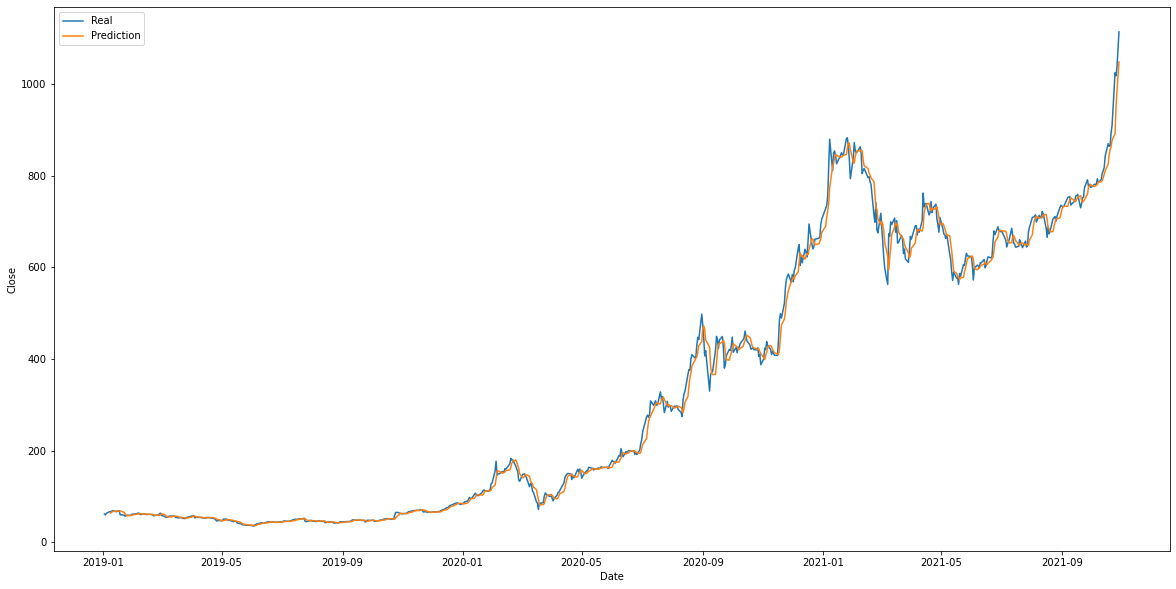

In [87]:
#Visualize
sns.lineplot(data=tmp, x="Date", y="Close", label="Real")
sns.lineplot(data=tmp, x="Date", y="Predictions",label="Prediction")

Luckily, we don't need to do this by hand, it is built into pandas. 

We can try...

Date
2019-01-02    62.023998
2019-01-03    60.950398
2019-01-04    61.990596
2019-01-07    63.638335
2019-01-08    64.623473
Name: Close, dtype: float64
23.935528641014564


<AxesSubplot:xlabel='Date', ylabel='Close'>

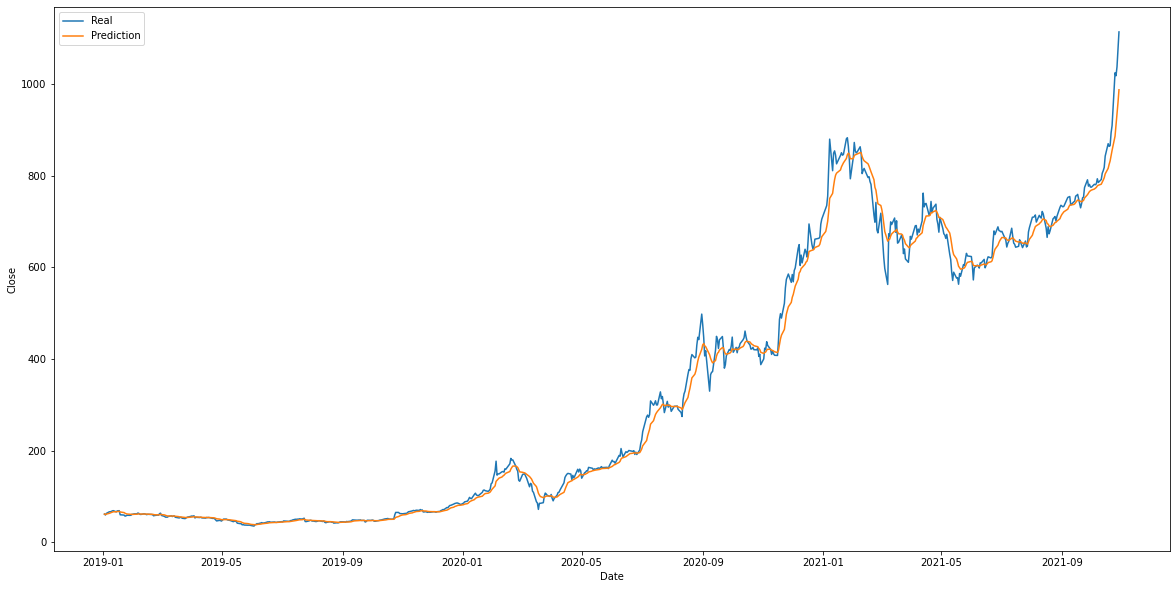

In [102]:
#Weighted Average
#NOTE - I think the book's function call is old. 
weightAvg = d_tsla["Close"].ewm(span=10).mean()
print(weightAvg.head())
print(mean_squared_error(d_tsla["Close"], weightAvg, squared=False))
#Visualize
sns.lineplot(data=d_tsla, x="Date", y="Close", label="Real")
sns.lineplot(data=weightAvg, label="Prediction")

This function does a similar thing to what we did in the dumb example, but it is a bit more flexible. In particular, you can specify how far back you want to look, and you can do so in a few ways:
<ul>
<li>Span - specify how may rows to look back. a = 2 / (span + 1)
<li>Com - as above. a = 1 / (1 + com)
<li>Halflife - specify how long (# of records) it takes for a value to be 1/2 as weighted in the calculation. a = 1 - exp( (-ln(2)) / halflife )
</ul>

Date
2019-01-02    62.023998
2019-01-03    61.014186
2019-01-04    61.914396
2019-01-07    63.318663
2019-01-08    64.176368
Name: Close, dtype: float64
45.373752741212655


<AxesSubplot:xlabel='Date', ylabel='Close'>

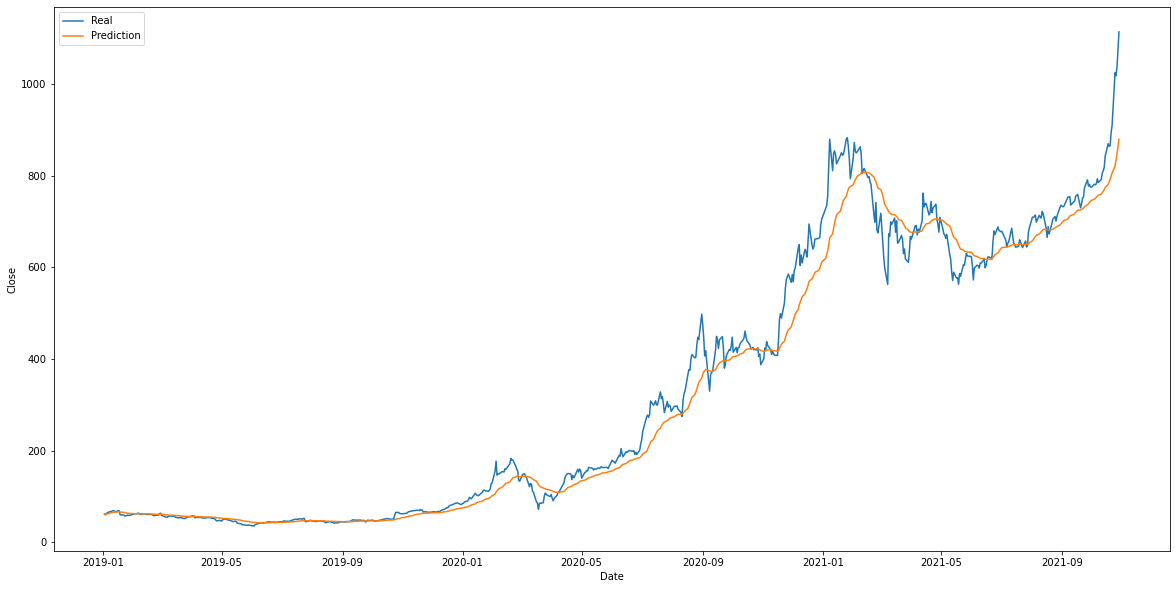

In [103]:
weightAvg = d_tsla["Close"].ewm(halflife=10).mean()
print(weightAvg.head())
print(mean_squared_error(d_tsla["Close"], weightAvg, squared=False))
#Visualize
sns.lineplot(data=d_tsla, x="Date", y="Close", label="Real")
sns.lineplot(data=weightAvg, label="Prediction")

<h2>Time Series Components</h2>

If we look at our data, we can identify 3 major components to the pattern:
<ul>
<li>Trend - are the values generally going up or down. 
<li>Seasonality - is there an up/down pattern that repeats over and over.
<li>Noise - junk data from random variation. 
</ul>

We can look at some other data that makes these more explicit than the real stock data. 

In [118]:
#Load some data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

/var/folders/px/vhm_920n7zx2wvqq_ht0q5tm0000gp/T/ipykernel_18553/2163958751.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

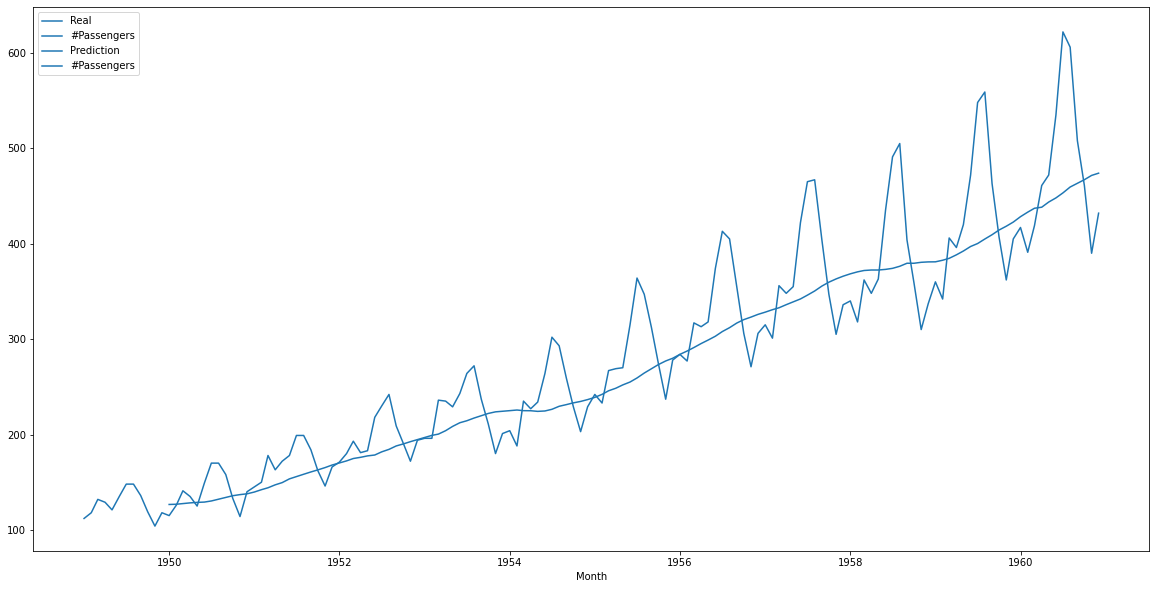

In [128]:
#Visualize
sns.lineplot(data=data, label="Real")
sns.lineplot(data=data.rolling(12, closed="left").mean(), label="Prediction")
#sns.lineplot(data=data.rolling(12, closed="left").var(), label="Var")

There's an upward trend here, there's also a pretty clear cyclical pattern. We can plot a 12 month moving average and it shoots right through the middle. However, all those ups and downs are details that we want to capture!

<H2>Stationary... or Not?<h2>

One concept that is important in time series stuff is if a time series is stationary, as defined by:
<ul>
<li>Mean is constant over time.
<li>Variance is constant over time.
</ul>

Basically, predicting something like the Tesla price above is hard to predict, so we do some transformations to make the data more simple. We then feed this simpler data to our time series models.

The easiest way to assess stationality is to just plot and look.

We'll first look to remove the trend...

<h2>Serial Correlation</h2>

Serial correlation is the correlation between values that are in a series. In English, this basically means that todays value is correlated with yesterdays value, and so on. So if gas prices are high today, we'd expect them to be pretty high tomorrow - or they have correlation between them. 

In [116]:
serCorr = thinkstats2.SerialCorr(d_tsla["Close"], 50)
serCorr

0.9220309475384209

<h1>Autocorrelation</h1>

